# Pigmento decomposition reimplementation

This is a reimplementation of the algorithm presented in ["Pigmento: Pigment-Based Image Analysis and Editing"](https://cragl.cs.gmu.edu/pigmento/) by Jianchao Tan, Stephen DiVerdi, Jingwan Lu and Yotam Gingold. We show this as an example usecase of the scans and oilpaint dataset released with this code. The algorithm uses only RGB information, even though we have hyperspectral information available. Please reach out to Ruben Wiersma (rubenwiersma@gmail.com) if you have interest in extending this approach for hyperspectral data.

First, load an image to decompose.

INFO:2025-02-13 15:05:27,601:jax._src.xla_bridge:945: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-02-13 15:05:27,602:jax._src.xla_bridge:945: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


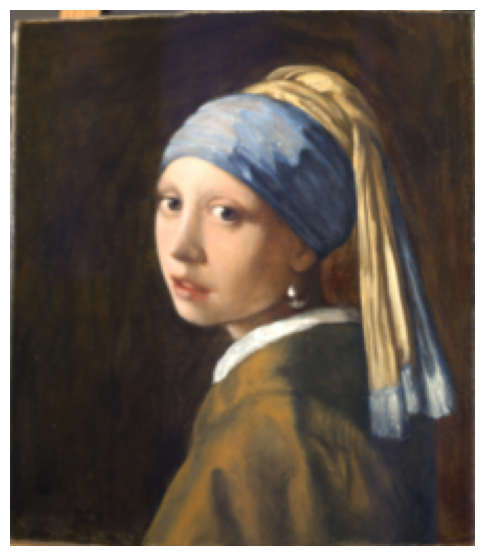

In [ ]:
import numpy as np
import scipy.io as sio
from skimage.transform import resize
from skimage.io import imread

from painting_tools.util.color import spectral_to_rgb
from painting_tools.util.plots import show_colors

# Load image with skimage
# TODO: update this path to the location of the processed data on your system
rgb = imread('/local/home/rwiersma/Documents/Paintings/Captures paintings 2023/processed/vermeer_girl/reflectance_vermeer_girl.png')[..., :3] / 255

# Resize image for fast processing
rgb = resize(rgb, (256, rgb.shape[1] * 256 / rgb.shape[0]), mode='reflect', anti_aliasing=True)
show_colors([rgb], scale=2)

## Load in the Oilpaint pigment database

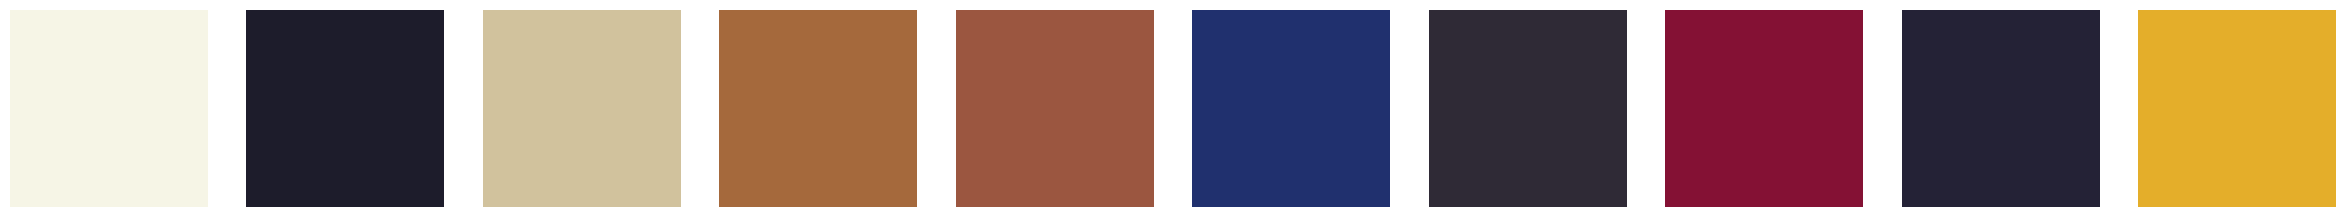

In [38]:
from painting_tools.measurements.pigments import PigmentDatabase
from painting_tools.rendering import kubelka_munk, kubelka_munk_opaque
from painting_tools.util import resample_wavelengths

# number of pigments K in palette
P = 8
# database of pigments
pigment_database = PigmentDatabase('oilpaint')
pigments, pigment_names = pigment_database['oilpaint']

def resample_pigments(pigments):
    new_k, new_wavelengths = resample_wavelengths(pigments[:, 1], pigments[:, 0])
    new_s, _ = resample_wavelengths(pigments[:, 2], pigments[:, 0])
    return np.stack([new_wavelengths, new_k, new_s], axis=1)

pigments = [resample_pigments(pigment) for pigment in pigments]
pigment_database.spectra = pigments[0][:, 0]

database_rgb_original = np.zeros((len(pigments), 3))
database_ks_original = np.zeros((len(pigments), pigments[0].shape[0], 2))
for i, pigment in enumerate(pigments):
    # reflectance = kubelka_munk(np.ones((1)), pigment[:, 1], pigment[:, 2], np.ones_like(pigment[:, 1]))
    reflectance = kubelka_munk_opaque(pigment[:, 1], pigment[:, 2])
    pigment_rgb = spectral_to_rgb(reflectance, pigment[:, 0])
    database_rgb_original[i] = pigment_rgb
    database_ks_original[i, :, 0] = pigment[:, 1]
    database_ks_original[i, :, 1] = pigment[:, 2]

show_colors([np.array(color) for color in database_rgb_original.tolist()])

And increase the database size by adding 1:1 combinations of pigments.

In [40]:
n_pigments = len(pigments)
database_rgb = np.zeros((n_pigments + n_pigments * (n_pigments - 1) // 2, 3))
database_rgb[:n_pigments] = database_rgb_original
database_ks = np.zeros((n_pigments + n_pigments * (n_pigments - 1) // 2, pigments[0].shape[0], 2))
database_ks[:n_pigments] = database_ks_original
count = 0
for i in range(n_pigments - 1):
    for j in range(i + 1, n_pigments):
        mix_k = 0.5 * pigments[i][:, 1] + 0.5 * pigments[j][:, 1]
        mix_s = 0.5 * pigments[i][:, 2] + 0.5 * pigments[j][:, 2]
        # reflectance = kubelka_munk(np.ones((1)), mix_k, mix_s, np.ones_like(pigment[:, 1]))
        reflectance = kubelka_munk_opaque(mix_k, mix_s)
        pigment_rgb = spectral_to_rgb(reflectance, pigments[i][:, 0])
        database_rgb[n_pigments + count] = pigment_rgb
        database_ks[n_pigments + count, :, 0] = mix_k
        database_ks[n_pigments + count, :, 1] = mix_s
        count += 1
        
print(f'Extended database to {database_rgb.shape[0]} pigments')

Extended database to 55 pigments


# Steps: 

1. Sample points from painting, using convex hull points; only work on this sample
2. Simplify convex hull using smallest adding volume edge collapses until K vertices is reached
    - Other options explored: k-means, alpha shape, Chang palette based
3. Choose initial parameters from nearest neighbor in database (Okumura)
4. Solve alternately:
    - Weights, L-BFGS-B: lower bounds 1e-15, upper bounds 1.0; objective: sparse (sqrt(max((1-square(W - 1)).sum))), smooth
    - Parameters, L-BFGS-B: lower bounds 1e-8, upper bounds inf; objective: gradient squared

## 1. Compute convex hull

In [41]:
# 1. Compute convex hull on rgb
from scipy.spatial import ConvexHull
from painting_tools.util import Mesh

hull = ConvexHull(rgb.reshape(-1, 3))

# Make mesh out of convex hull
vertices = hull.points[hull.vertices]
hull_to_vertex_idx = np.zeros(hull.points.shape[0], dtype=np.int32)
hull_to_vertex_idx[hull.vertices] = np.arange(len(hull.vertices))
faces = hull_to_vertex_idx[hull.simplices]
mesh = Mesh(vertices, faces)

## 2. Simplify convex hull

In [42]:
from painting_tools.util import edge_contract_smallest_added_volume

max_iter = 500
simplified_hull = mesh
for it in range(max_iter):
    simplified_hull = edge_contract_smallest_added_volume(simplified_hull)

    if len(simplified_hull.vertices) == P:
        break

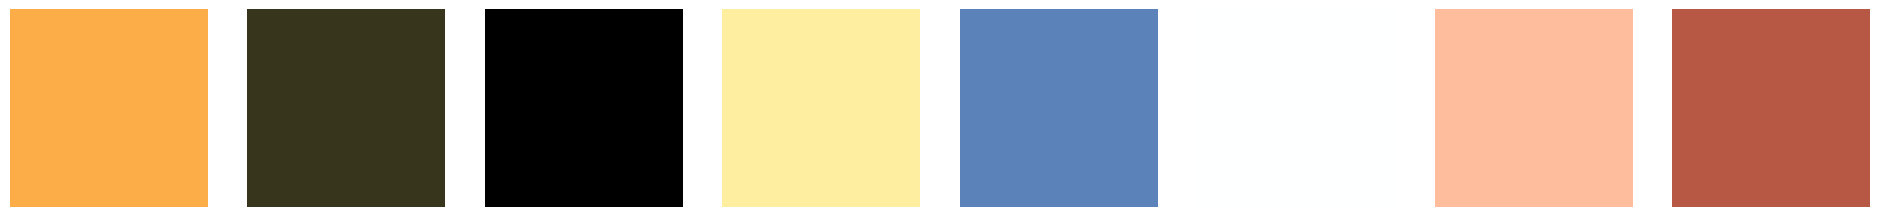

In [43]:
show_colors([np.array(color) for color in simplified_hull.vertices.tolist()])

## 3. Select parameters from database

Colors found


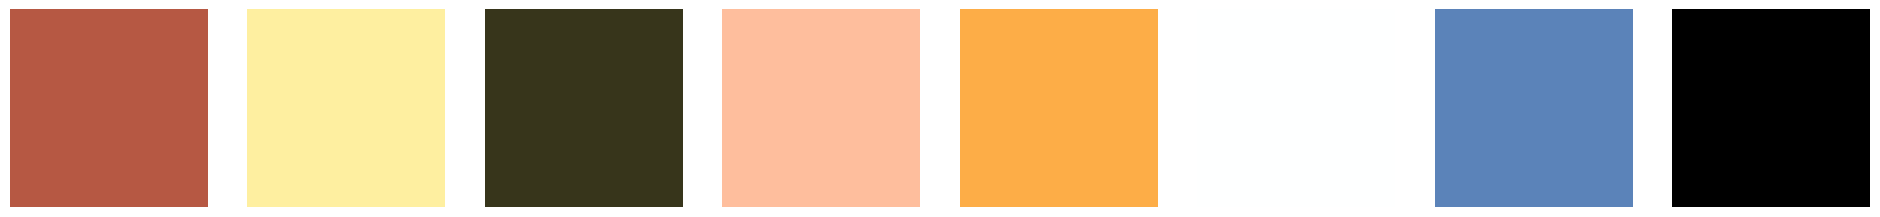

Matched from database


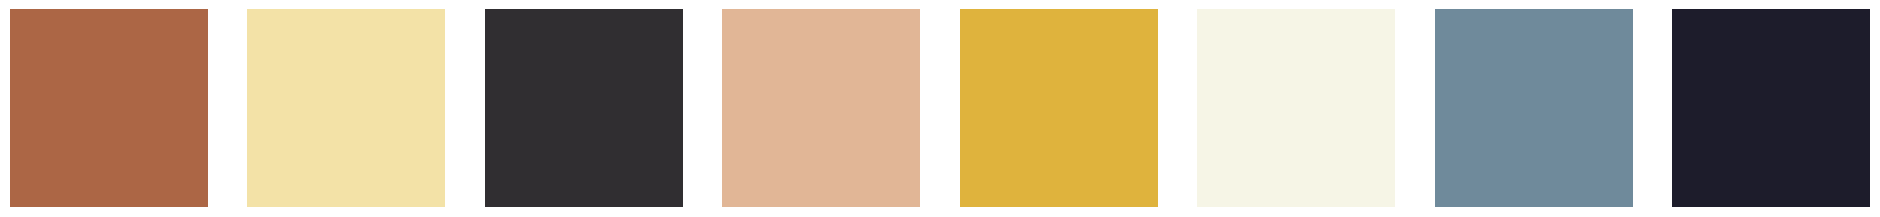

In [44]:
diff = np.square(simplified_hull.vertices[None] - database_rgb[:, None]).sum(axis=-1)
min_indices = np.argmin(diff,axis=0)
min_diff = diff[min_indices, np.arange(P)]
sort_idx = np.argsort(min_diff)
min_indices = min_indices[sort_idx]
min_diff = min_diff[sort_idx]

new_min_indices = min_indices.copy()

for i in range(P-1):
    diff[min_indices[i]] = np.inf
    for j in range(i+1,P):
        if min_indices[i]==min_indices[j]:
            temp_diff=diff[:,j]
            ind=np.argsort(temp_diff)[1]
            new_min_indices[j]=ind
            min_diff[j]=temp_diff[ind]

nearest_pigments = new_min_indices

# Show found colors
print('Colors found')
show_colors([np.array(color) for color in simplified_hull.vertices[sort_idx].tolist()])
print('Matched from database')
show_colors([np.array(color) for color in database_rgb[nearest_pigments].tolist()])

# 4. Start optimization


First create the loss function and initialize parameters.

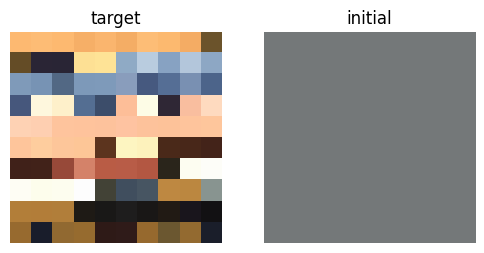

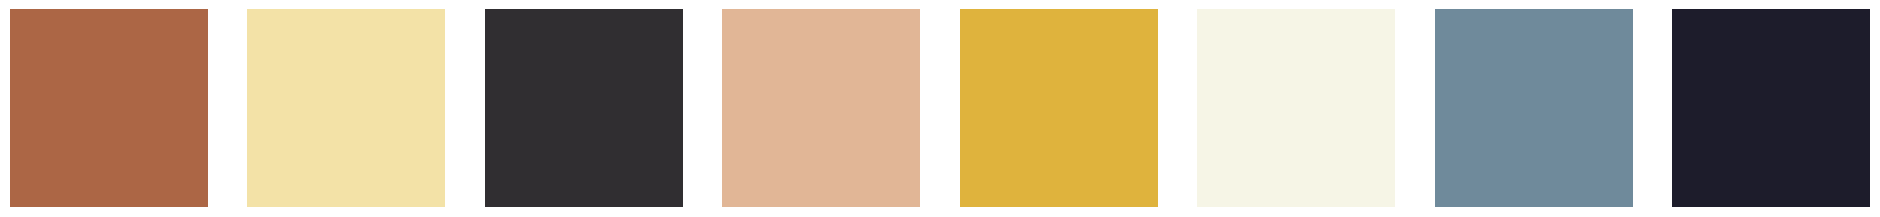

In [46]:
from painting_tools.rendering.kubelka_munk import mix_pigments, kubelka_munk, kubelka_munk_opaque
from painting_tools.util.color import gamma_to_linear, linear_to_gamma
from painting_tools.util.operators import gradient
import jax.numpy as jnp
from jaxopt import ScipyBoundedMinimize

# Regularizer weights
reg_weight_sum = 10.0
reg_weight_sparsity = 0.0
reg_weight_spatial_smoothness = 0.0
reg_k_smoothness = 0.001
reg_s_smoothness = 0.001

# Initialize parameters

# Target image - start optimization on only the hull vertices
# And remove gamma encoding
target = gamma_to_linear(hull.points[hull.vertices])
# target = gamma_to_linear(rgb.reshape(-1, 3))

# Absorption and scattering - from nearest pigments of convex hull
k_and_s = jnp.stack([database_ks[pigment] for pigment in nearest_pigments], axis=0)

# Mixing weights
w = jnp.ones((target.shape[0], P)) / P

# Define Energy function to be minimized
def render_painting(w, k_and_s, spectra=pigment_database.spectra):
    """
    Renders an image with Kubelka-Munk, given:
    w : jax.numpy array, mixing weights.
        [N, P] N number of pixels, P number of pigments
    k_and_s : jax.numpy array, absorption and scattering coefficient per pigment and wavelength.
        [P, L, 2] P number of pigments, L number of wavelengts
    """
    w = w / w.sum(axis=-1, keepdims=True).clip(1e-15)          # [N, P]
    k_and_s = (w[..., None, None] * k_and_s[None]).sum(axis=1) # [N, P, 1, 1] x [1, P, L, 2] -> [N, P, L, 2] -> [N, L, 2]
    k, s = k_and_s[..., 0], k_and_s[..., 1]                    # [N, L, 2] -> [N, L], [N, L]
    # reflection = kubelka_munk(jnp.ones((1, w.shape[0])), k[None], s[None], jnp.ones_like(k[None])) # [1, N, L]
    reflection = kubelka_munk_opaque(k[None], s[None]) # [1, N, L]
    return spectral_to_rgb(reflection, spectra, apply_gamma=False)[0]


def reconstruction_energy(w, k_and_s, target):
    """
    Renders an image with Kubelka-Munk, given:
    w : jax.numpy array, mixing weights.
        [N, P] N number of pixels, P number of pigments
    k_and_s : jax.numpy array, absorption and scattering coefficient per pigment and wavelength.
        [P, L, 2] P number of pigments, L number of wavelengts
    target : jax.numpy array, target image (rgb), NO gamma correction should be applied.
        [N, 3] N number of pixels, RGB values.
    """
    rgb = render_painting(w, k_and_s)

    # Define losses
    return jnp.square(rgb - target).sum()
    
def w_energy(w, target=target, k_and_s=k_and_s):
    weight_smoothness_energy = 0
    if w.ndim == 3:
        weight_smoothness_energy = reg_weight_spatial_smoothness * jnp.square(gradient(w)).sum()
        w = w.reshape(-1, w.shape[2])
    reconstr_energy = reconstruction_energy(w, k_and_s, target)

    weight_sum_energy = reg_weight_sum * jnp.square(w.sum(axis=1) - 1).sum()
    weight_sparsity_energy = reg_weight_sparsity / P * jnp.maximum((1 - jnp.square(w - 1.0)).sum(axis=1), 1e-15).sum()
    
    return reconstr_energy + weight_sum_energy + weight_sparsity_energy + weight_smoothness_energy

def k_and_s_energy(k_and_s):
    reconstr_energy = reconstruction_energy(w, k_and_s, target)

    # Gradient on k and s over spectra
    # makes sure we have a smooth spectral signal.
    smoothness_energy = jnp.square(k_and_s[:, :-1] - k_and_s[:, 1:])
    smoothness_energy = reg_k_smoothness * smoothness_energy[..., 0].sum() + reg_s_smoothness * smoothness_energy[..., 1].sum()

    return reconstr_energy + smoothness_energy


# Check shapes
k_and_s.shape, w.shape, target.shape

out_width = np.sqrt(target.shape[0]).astype(int)
num_pixels = out_width * out_width
show_colors([linear_to_gamma(target[:num_pixels].reshape(out_width, out_width, 3)), linear_to_gamma(render_painting(w, k_and_s)[:num_pixels].reshape(out_width, out_width, 3))], ['target', 'initial'])

initial_pigments_rgb = render_painting(np.eye(P), k_and_s)
show_colors([linear_to_gamma(np.array(color)) for color in initial_pigments_rgb.tolist()])

Now setup the optimizer for **weights** and **k_and_s** alternatingly.

Starting optimization


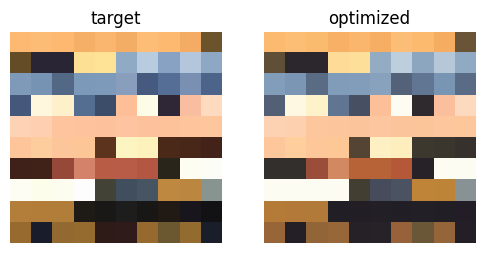

Energy: 0.07524293661117554


In [48]:
max_ANLS_iter = 10

print('Starting optimization')
for it in range(max_ANLS_iter):
    # Optimize weights
    bounds_w = (1e-15 * jnp.ones_like(w), jnp.ones_like(w))
    optimizer_w = ScipyBoundedMinimize(fun=w_energy, method='l-bfgs-b')
    w = optimizer_w.run(w, bounds=bounds_w).params

    # Optimize k_and_s
    bounds_ks = (1e-15 * jnp.ones_like(k_and_s), jnp.inf * jnp.ones_like(k_and_s))
    optimizer_ks = ScipyBoundedMinimize(fun=k_and_s_energy, method='l-bfgs-b')
    k_and_s = optimizer_ks.run(k_and_s, bounds=bounds_ks).params


show_colors([linear_to_gamma(target[:num_pixels].reshape(out_width, out_width, 3)), linear_to_gamma(render_painting(w, k_and_s)[:num_pixels].reshape(out_width, out_width, 3))], ['target', 'optimized'])
print(f'Energy: {reconstruction_energy(w, k_and_s, target)}')

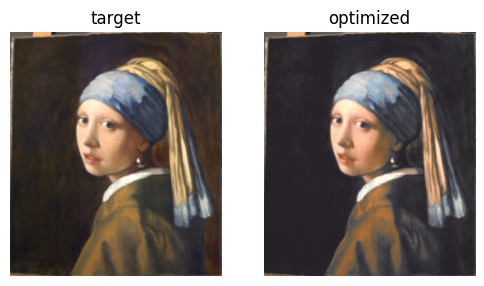

In [49]:
# Find weights for full image
target_full = gamma_to_linear(rgb.reshape(-1, 3))
w = jnp.ones((rgb.shape[0], rgb.shape[1], P)) / P

# Optimize weights
bounds_w = (1e-8 * jnp.ones_like(w), jnp.ones_like(w))
optimizer_w_full = ScipyBoundedMinimize(fun=lambda w: w_energy(w, target_full), method='l-bfgs-b')
w = optimizer_w_full.run(w, bounds=bounds_w).params.reshape(-1, P)

show_colors([linear_to_gamma(target_full.reshape(rgb.shape)), linear_to_gamma(render_painting(w, k_and_s).reshape(rgb.shape))], ['target', 'optimized'])

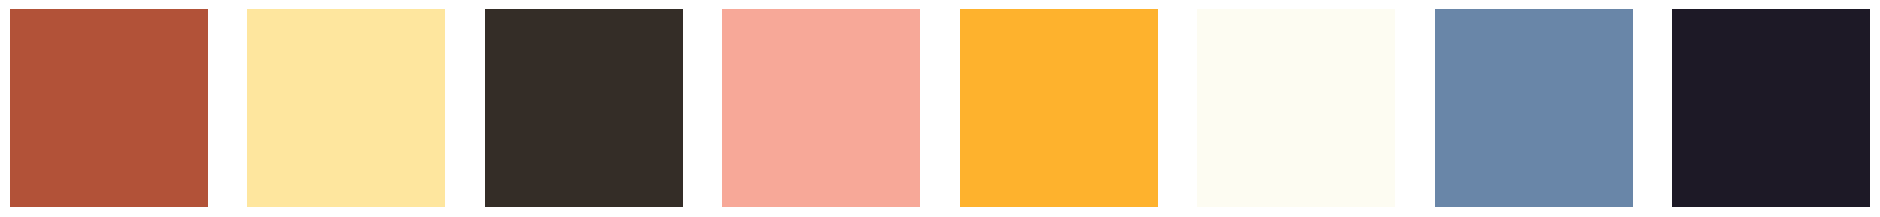

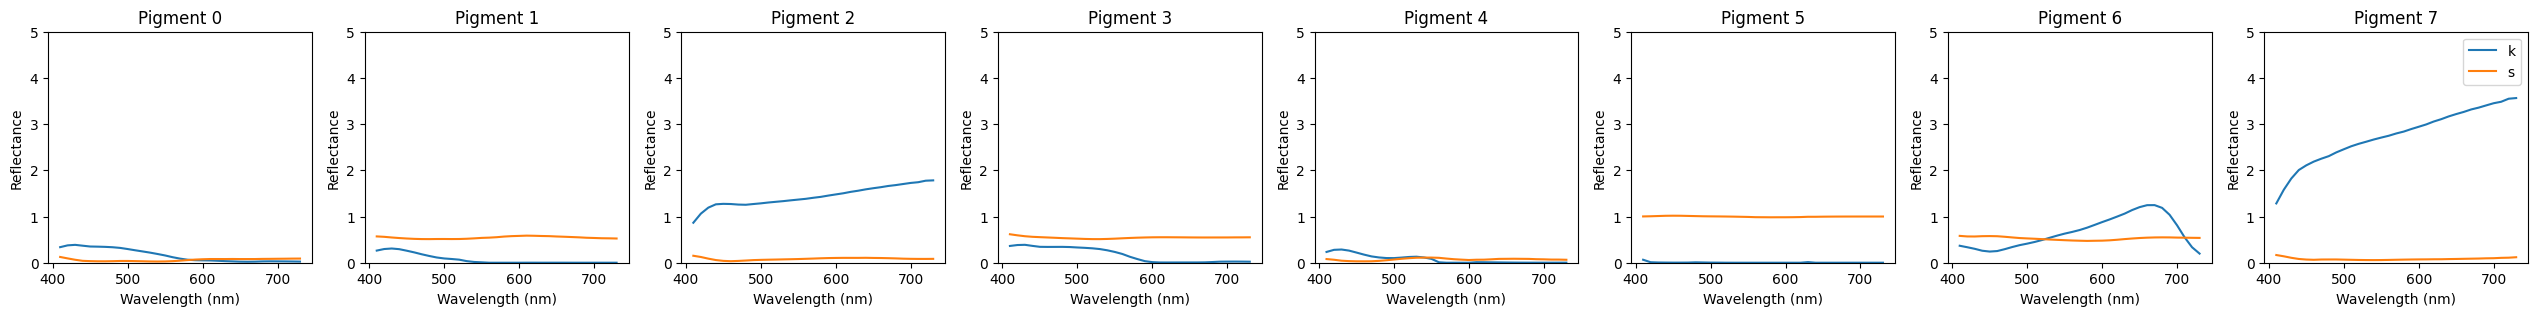

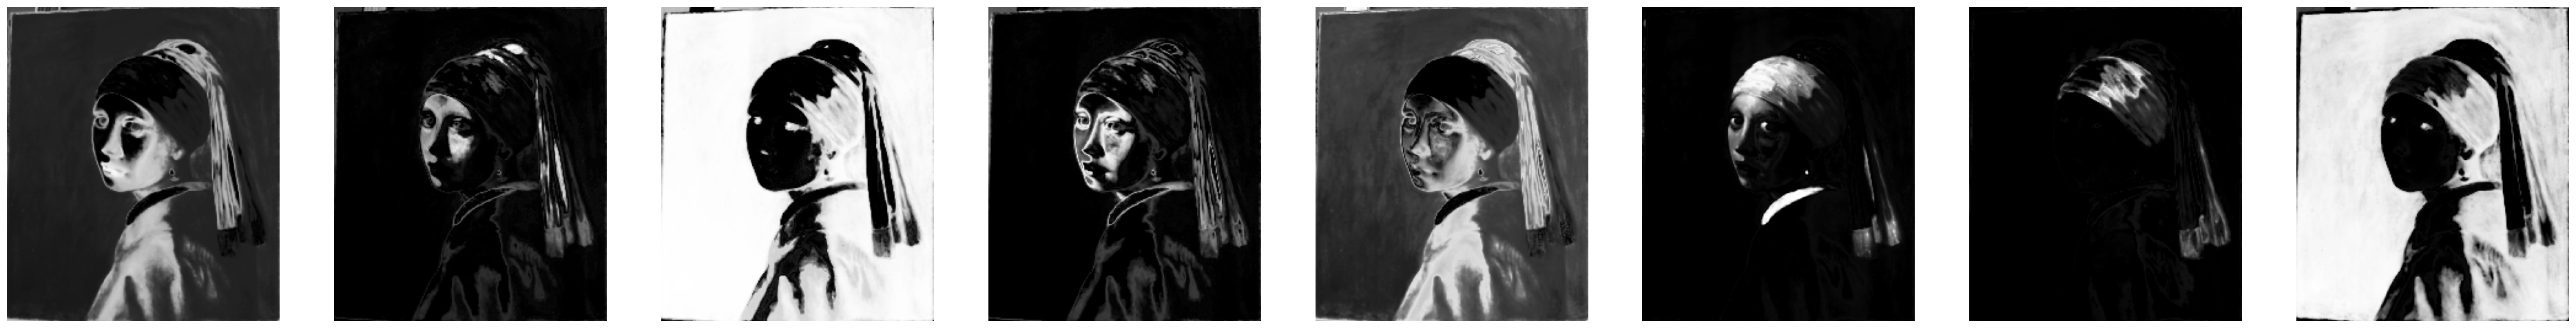

In [50]:
import matplotlib.pyplot as plt

# Show optimized k_and_s
optimized_pigments_rgb = linear_to_gamma(render_painting(np.eye(P), k_and_s))
# show_colors([optimized_pigments_rgb.reshape(2, 3, 3), database_rgb[nearest_pigments].reshape(3, 3, 3)], ['optimized', 'initial pigments'])
show_colors([np.array(color) for color in optimized_pigments_rgb.tolist()])

# Plot each spectrum as a line plot using Matplotlib's subfigure
fig, axes = plt.subplots(1, P, figsize=(P * 4, 3))
for i, ax in enumerate(axes):
    ax.plot(pigment_database.spectra, k_and_s[i], label=['k', 's'])
    ax.set_ylim(0, 5)
    ax.set_title(f'Pigment {i}')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Reflectance')
plt.legend()
plt.show()

show_colors([w[..., p].reshape(*rgb.shape[:2], 1) for p in range(P)], scale=2)